In [43]:
import pandas as pd
import xarray as xr
import numpy as np

# matplotlib import
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
from matplotlib import gridspec,rc
import matplotlib.patches as patches
import netCDF4

In [44]:
# import mask
file = '/home/archive/REANALYSES/ERA5/Invariant_fields/ERA5_lsm.nc'
ds = xr.open_dataset(file)

# transform dataset into dataframe
df_mask = ds.to_dataframe().reset_index()

# import filtered ETCs
fetc = pd.read_csv("/pampa/cloutier/storm_tracks/filtered/etc24_consec_season.csv", index_col=0)

# add sea land mask (lsm) in filtered ETCs dataframe 
fetc_lsm = fetc.merge(df_mask, how='left', on=['latitude', 'longitude'])
fetc_lsm = fetc_lsm.fillna(value = 0)
fetc_lsm = fetc_lsm.drop('time', axis=1)

# Limit chosen for land sea mask : 
# lsm <= 0.7 -> sea mask
# lsm > 0.7 -> land mask

ds.close()

In [45]:
# Choose radius
#02 for 200km or 08 for 800km 
r = '08'

# Choose mask 
#mask = 'land'
#mask = 'sea'
mask = 'no_mask'

# Choose the variables to compare 10WS with
# choices : 85WS (850 hPa wind speed)
#           PREC (Total precip accumulation on an hour)
var = '85WS'

# 6 first hours are not available for PREC_av08
# fetc_lsm = fetc_lsm.drop([0,1,2,3,4,5])

if var == 'PREC' : 
    fetc_lsm = fetc_lsm.drop([0,1,2,3,4,5])

In [46]:
# Only keep storm center within crcm6 domain
fetc_true = fetc_lsm.loc[fetc_lsm.HU == True].copy()

# Modify fetc_true if we want to add a mask
if mask == 'land' : 
    fetc_true = fetc_true.loc[fetc_lsm.lsm > 0.7].copy() 
    
if mask == 'sea' :
    fetc_true = fetc_true.loc[fetc_lsm.lsm <= 0.7].copy() 

# Get mean of variables for each storm and separate by season 
fetc_avg = fetc_true.groupby(['storm', 'season']).agg({f"{var}_av{r}": 'mean', f"10WS_av{r}": 'mean'}).reset_index()

# Calculate the all season mean and standard deviation
mean_10 = fetc_avg[f"10WS_av{r}"].mean()
mean_var = fetc_avg[f"{var}_av{r}"].mean()
std_10 = fetc_avg[f"10WS_av{r}"].std()
std_var = fetc_avg[f"{var}_av{r}"].std()

# normalize the values of fetc_avg
fetc_avg[f"n_{var}_avR"] = (fetc_avg[f"{var}_av{r}"] - mean_var) / std_var
fetc_avg[f"n_10WS_avR"] = (fetc_avg[f"10WS_av{r}"] - mean_10) / std_10

In [47]:
# separate data by season
seasons = ['JJA', 'SON', 'DJF', 'MAM']
columns = [f"n_{var}_avR", "n_10WS_avR"]

# Dictionnary that will store all the normalized values 
# in each season
n_avR_szn={}

# Loop through each season and column suffix to extract the data and create arrays
for season in seasons:
    for suffix in columns:
        array_name = f"{suffix}_{season.lower()}"
        n_avR_szn[array_name] = fetc_avg.loc[fetc_avg['season'] == season][suffix]

In [48]:
# count the number of occurences per season and per quadrant

quadrant = ['1', '2', '3', '4']
seasons = ['JJA', 'SON', 'DJF', 'MAM']

# Dictionnary that will store the count for each season
# in each quadrant
q_count = {}

# Store the seasonnal sum 
tot_szn_q = {}

for s in seasons : 
    tot_szn_q[s] = 0
    
for q in quadrant : 
    for s in seasons :
        var_name = f"{s.lower()}_{q}"
        cond_1 = (fetc_avg[f'n_{var}_avR'] > 1)
        cond_2 = (fetc_avg[f'n_{var}_avR'] <= 1)
        cond_3 = (fetc_avg['n_10WS_avR'] <= 1)
        cond_4 = (fetc_avg['n_10WS_avR'] > 1)
        
        if q == '1' : 
            q_count[var_name] = len(fetc_avg.loc[(fetc_avg['season'] == s) & cond_1 & cond_4])
            tot_szn_q[s] += q_count[var_name]
            
        elif q == '2' : 
            q_count[var_name] = len(fetc_avg.loc[(fetc_avg['season'] == s) & cond_2 & cond_4])
            tot_szn_q[s] += q_count[var_name]
        
        elif q == '3' : 
            q_count[var_name] = len(fetc_avg.loc[(fetc_avg['season'] == s) & cond_2 & cond_3])
            tot_szn_q[s] += q_count[var_name]
            
        elif q == '4' : 
            q_count[var_name] = len(fetc_avg.loc[(fetc_avg['season'] == s) & cond_1 & cond_3])
            tot_szn_q[s] += q_count[var_name]

            
# percentage of occurence of quadrant count 

pct_szn_q = {}

for q in quadrant : 
    for s in seasons : 
        var_name=f"{s.lower()}_{'pct'}_{q}"
        var_q_count = f"{s.lower()}_{q}"
        pct_szn_q[var_name] = 100 * (q_count[var_q_count] / tot_szn_q[s])

In [49]:
# averaged value of wind speed ratio
szn_mean = fetc_avg.groupby(['season']).agg({f'10WS_av{r}' : 'mean', f'{var}_av{r}' : 'mean'}).reset_index()
ratio = szn_mean[f'10WS_av{r}'] / szn_mean[f'{var}_av{r}']

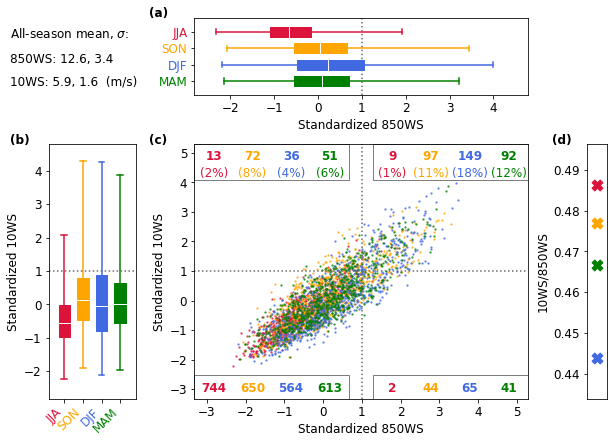

In [50]:
#import numpy as np

fs1 = 12
fs2 = 14
a = 0.6
s = 2

colors = ['crimson', 'orange', 'royalblue', 'green']
col_rows = ['crimson', 'orange', 'royalblue', 'green', 'crimson', 'orange', 'royalblue', 'green']
norm_10ws = ['n_10WS_avR_jja', 'n_10WS_avR_son', 'n_10WS_avR_djf', 'n_10WS_avR_mam']
norm_var = [f'n_{var}_avR_jja', f'n_{var}_avR_son', f'n_{var}_avR_djf', f'n_{var}_avR_mam']

# get the min and max normalized values
all_values = [value for values in n_avR_szn.values() for value in values]
min_x = min(all_values) 
max_x = max(all_values) 

################################################
### TEXT BOX CONFIGURATION FOR MIDDLE FIGURE ###
################################################

# Define the box dimensions for middle figure quadrants
props=dict(boxstyle='round',facecolor='white', alpha=0.2)
box_width = 4
box_height_1 = 1.2
box_height_2 = 0.8

# Text to display in each quadrant 
q1_vals = [[str(q_count['jja_1']), str(q_count['son_1']), 
            str(q_count['djf_1']), str(q_count['mam_1'])],
            ['('+'{:,.0f}'.format(pct_szn_q['jja_pct_1'])+'%)', 
             '('+'{:,.0f}'.format(pct_szn_q['son_pct_1'])+'%)',
             '('+'{:,.0f}'.format(pct_szn_q['djf_pct_1'])+'%)', 
             '('+'{:,.0f}'.format(pct_szn_q['mam_pct_1'])+'%)']]

q2_vals = [[str(q_count['jja_2']), str(q_count['son_2']), 
            str(q_count['djf_2']), str(q_count['mam_2'])],
            ['('+'{:,.0f}'.format(pct_szn_q['jja_pct_2'])+'%)', 
             '('+'{:,.0f}'.format(pct_szn_q['son_pct_2'])+'%)',
             '('+'{:,.0f}'.format(pct_szn_q['djf_pct_2'])+'%)', 
             '('+'{:,.0f}'.format(pct_szn_q['mam_pct_2'])+'%)']]

q3_vals = [[str(q_count['jja_3']), str(q_count['son_3']), 
           str(q_count["djf_3"]), str(q_count['mam_3'])]]

q4_vals = [[str(q_count['jja_4']), str(q_count['son_4']), 
           str(q_count['djf_4']), str(q_count['mam_4'])]]

q_vals = [q1_vals, q2_vals, q3_vals, q4_vals]

# Keep track in which quadrant we are 
q_i = [1,2,3,4]

#######################
### MIDDLE FIGURE  ###
#######################

if var == 'PREC' : 
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('Standardized PREC',fontsize=fs1)

if var == '85WS' : 
    fig = plt.figure(figsize=(10,7))
    gs = gridspec.GridSpec(2,3,width_ratios=[0.26,1.0,0.06], height_ratios=[0.3,1.], hspace=0.3, wspace=0.4)
    ax=plt.subplot(gs[4])
    ax.set_xlabel('Standardized 850WS',fontsize=fs1)

# Add the scatter plot
for nvar, n10, c in zip(norm_var, norm_10ws, colors) : 
    cf = plt.scatter(n_avR_szn[nvar], n_avR_szn[n10] , s=s, color=c, alpha=a, edgecolor=c)

plt.xlim(min_x - 1,max_x + 1)
plt.ylim(min_x - 1, max_x + 1)

# for PREC, r = 02, these limits are necessary
#     plt.xlim(min_x - 1,max_x - 1)
#     plt.ylim(min_x - 1, max_x - 1)

ax.set_ylabel('Standardized 10WS',fontsize=fs1)
ax.tick_params(axis='both', labelsize=fs1)


# Corner coordinates of the graphic
ur_x, ur_y = ax.get_xlim()[1] - box_width, ax.get_ylim()[1] - box_height_1
ul_x, ul_y = ax.get_xlim()[0], ax.get_ylim()[1] - box_height_1
ll_x, ll_y = ul_x, ax.get_ylim()[0] 
lr_x, lr_y = ur_x, ll_y

x_values = [ur_x, ul_x, ll_x, lr_x]
y_values = [ur_y, ul_y, ll_y, lr_y]

i = 1

# Create a rectangle patch and add it to the subplot
for x, y in zip(x_values, y_values) : 
    if i <= 2 : 
        box_height = box_height_1
    else : 
        box_height = box_height_2

    rect = patches.Rectangle((x, y), box_width, box_height, transform=ax.transData, 
                            facecolor='white', edgecolor = 'black', alpha=0.5, zorder=2)
    ax.add_patch(rect)
    i += 1

# Add the count and (%) for every season in each quadrant
for qi, q, x, y in zip(q_i, q_vals, x_values, y_values) : 
    for i, row in enumerate(q):
        for j, val in enumerate(row):

            # the first two quadrant have a bigger box than the quadrants 3 and 4
            box_height = box_height_1 if i == 0 else box_height_2

            # Bold font to first row
            fontweight = 'bold' if i == 0 else 'normal'

            # precision to adjust the position of the text depending on the quadrant
            prec = 1.1 if qi <= 2 else 1.8

            color = col_rows[j % len(col_rows)]
            x_pos = x + j * (box_width / 4) + (box_width / 8)
            y_pos = y - i * (box_height / 2.5) - (box_height / 4) + (box_height/prec)
            ax.text(x_pos, y_pos, val, color=color, fontsize=12, ha='center', va='center', weight=fontweight)

plt.axhline(y=1, color='dimgray', linestyle=':')
plt.axvline(x=1, color='dimgray', linestyle=':', zorder=1)

##################################################
################ FOR VAR == 850WS ################
##################################################

if var == '85WS' : 
    
    ######################
    #### boxplot 85WS ####
    ######################

    ax3=plt.subplot(gs[1])
    positions = [0, 0.6, 1.2, 1.8]

    for c, p, n85 in zip(reversed(colors), positions, reversed(norm_var)) :  

        bp = plt.boxplot(n_avR_szn[n85],positions=[p],vert=False,widths=0.37,patch_artist=True,
                boxprops=dict(facecolor=c, color=c),
                capprops=dict(color=c, linewidth=1.5),
                whiskerprops=dict(color=c, linewidth=1.5),
                flierprops=dict(color=c, markeredgecolor=c, linewidth=1.5),
                whis=[0,100],
                medianprops=dict(color='white'),showfliers=False)

    plt.axvline(1, color='dimgray', linestyle=':')
    ax3.tick_params(axis='x', labelsize=12)
    plt.xlim(min_x - 0.5, max_x + 0.5)

    ax3.set_xlabel('Standardized 850WS',fontsize=fs1)
    ax3.set_yticklabels(['MAM','DJF','SON','JJA'],ha='right',fontsize=fs1)
    ax3.set_xlabel('Standardized 850WS', fontsize=fs1)

    # set season label colors
    for xtick, color in zip(ax3.get_yticklabels(), reversed(colors)):
        xtick.set_color(color)

    ######################  
    #### boxplot 10WS ####
    ###################### 

    ax0=plt.subplot(gs[3])

    for c, p, n10 in zip(colors, positions, norm_10ws) : 

        bp = plt.boxplot(n_avR_szn[n10],positions=[p],widths=0.37,patch_artist=True,
                boxprops=dict(facecolor=c, color=c),
                capprops=dict(color=c, linewidth=1.5),
                whiskerprops=dict(color=c, linewidth=1.5),
                flierprops=dict(color=c, markeredgecolor=c, linewidth=1.5),
                whis=[0,100],
                medianprops=dict(color='white'),showfliers=False)

    plt.axhline(1, color='dimgray', linestyle=':')
    plt.ylim(min_x - 0.5, max_x + 0.5)
    plt.yticks(fontsize=fs1)

    ax0.set_ylabel('Standardized 10WS',fontsize=fs1)
    ax0.set_xticks([0,0.6,1.2,1.8])
    ax0.set_xticklabels(['JJA','SON','DJF','MAM'],rotation=45,ha='right',fontsize=fs1)
    colors = ['crimson', 'orange', 'royalblue','green']
    for xtick, color in zip(ax0.get_xticklabels(), colors):
        xtick.set_color(color)

    ############################
    #### ratio 10WS / 850WS ####
    ############################

    ax4=plt.subplot(gs[5])
    
    # ratio are in this order : DJF, JJA, MAM, SON
    colors_ratio = ['royalblue', 'crimson', 'green', 'orange']
    for i, c in zip(range(0,4), colors_ratio) :
        ax4.scatter(1.8, ratio[i], s=120, c=c, marker="X")

    min_r = ratio.min() - 0.01
    max_r = ratio.max() + 0.01
    
    tick_min = round(min_r, 2)
    tick_max = round(max_r, 2)
    
    plt.yticks(ticks=np.arange(tick_min, tick_max, 0.01))
    plt.ylim(min_r,max_r)
    plt.xlim(1.78,1.82)
    plt.yticks(fontsize=fs1)

    ax4.set_ylabel('10WS/850WS',fontsize=fs1)
    ax4.set_xticks([])

    ####################################################
    #### Upper left corner all seasons mean and std ####
    ####################################################

    ax0.text(-0.45,1.42,'All-season mean, $\sigma$:',color='k',transform=ax0.transAxes,ha='left',fontsize=fs1)
    ax0.text(-0.45,1.23,'10WS: '+str('{:,.1f}'.format(mean_10))+', '+str('{:,.1f}'.format(std_10))+'  (m/s)',
             color='k',transform=ax0.transAxes,ha='left',fontsize=fs1)
    ax0.text(-0.45,1.32,'850WS: '+str('{:,.1f}'.format(mean_var))+', '+str('{:,.1f}'.format(std_var))+'',
             color='k',transform=ax0.transAxes,ha='left',fontsize=fs1)
    
    # Add figure indexes 
    ax0.text(1.15, 1.5, '(a)',transform=ax0.transAxes,ha='left',fontsize=fs1,weight='semibold')
    ax0.text(-0.45, 1, '(b)',transform=ax0.transAxes,ha='left',fontsize=fs1,weight='semibold')
    ax0.text(1.15, 1, '(c)',transform=ax0.transAxes,ha='left',fontsize=fs1,weight='semibold')
    ax0.text(5.8, 1, '(d)',transform=ax0.transAxes,ha='left',fontsize=fs1,weight='semibold')

#plt.savefig(f'/pampa/cloutier/fig/paperChen_fig2/paperChen_fig2_{mask}_R{r}_10WS_{var}.png', dpi=300, bbox_inches='tight')